In [3]:
import time
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pyaudio
import librosa
import librosa.display
import realtime_analysis as ra

In [4]:
plt.rcParams["figure.figsize"] = (14, 4)

# record/load audio

In [7]:
RATE = 44100
CHANNELS = 1
SAMPLES_PER_BUFFER = 1024
duration = 8
total_length = int(8*RATE)
print("buffer length:", SAMPLES_PER_BUFFER/RATE)

x = np.zeros(total_length, dtype=np.float32)
t = librosa.samples_to_time(np.arange(x.shape[0]), sr=RATE)
x_index = 0
def input_callback(in_data, frame_count, time_info, status):
    global x_index
    
    if x_index+frame_count > x.shape[0]:
        return None, pyaudio.paComplete

    audio_data = np.frombuffer(in_data, dtype=np.float32)
    x[x_index:x_index+frame_count] = audio_data
    x_index += frame_count

    return in_data, pyaudio.paContinue

print("recording...")

p = pyaudio.PyAudio()

input_stream = p.open(format=pyaudio.paFloat32,
                      channels=CHANNELS,
                      rate=RATE,
                      input=True,
                      output=False,
                      frames_per_buffer=SAMPLES_PER_BUFFER,
                      stream_callback=input_callback)
input_stream.start_stream()

while input_stream.is_active():
    time.sleep(0.1)

input_stream.stop_stream()
input_stream.close()

p.terminate()

print("finish!")

buffer length: 0.023219954648526078
recording...
finish!


In [6]:
x, RATE = librosa.load("test2.wav")
t = librosa.samples_to_time(np.arange(x.shape[0]), sr=RATE)

print("sample timespan:", x.shape[0]/RATE)

sample timespan: 6.058684807256236


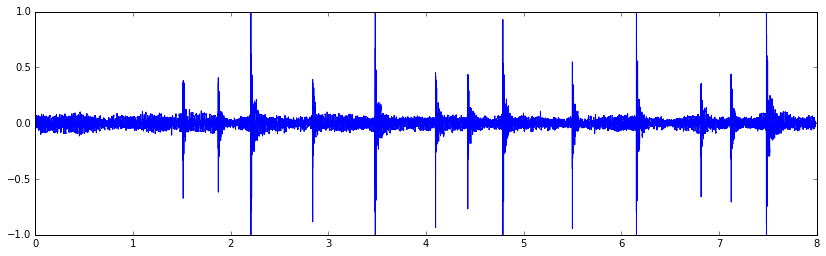

In [8]:
plt.plot(t, x)
# librosa.display.waveplot(x, RATE)

# spectrum

In [9]:
WIN_LENGTH = 1024
HOP_LENGTH = 512
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039


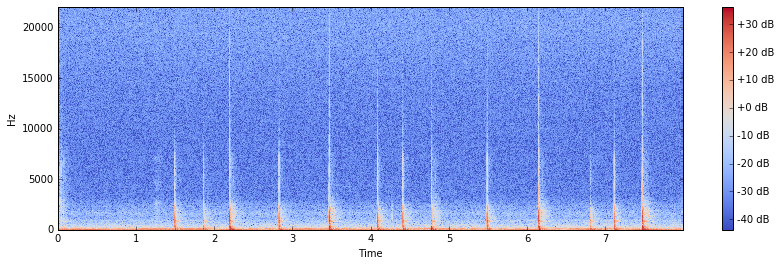

In [10]:
X = librosa.stft(x, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH, center=False)
Xdb = librosa.amplitude_to_db(abs(X))
t_frames = librosa.frames_to_time(np.arange(X.shape[1]), sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

librosa.display.specshow(Xdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

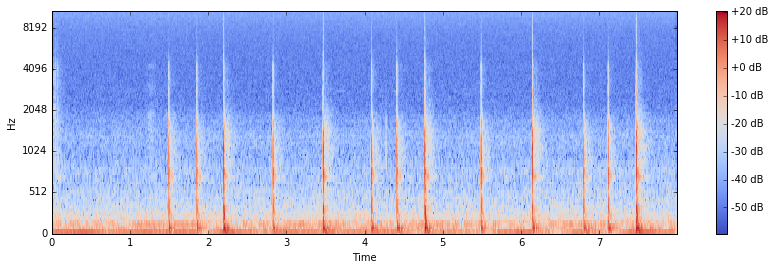

In [11]:
M = librosa.feature.melspectrogram(S=abs(X)**2, sr=RATE, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)
Mdb = librosa.power_to_db(M)

librosa.display.specshow(Mdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")

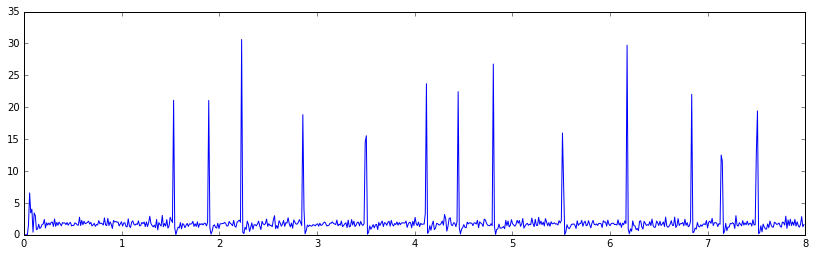

In [12]:
onset_env = librosa.onset.onset_strength(S=Mdb, sr=RATE)
plt.plot(t_frames, onset_env)

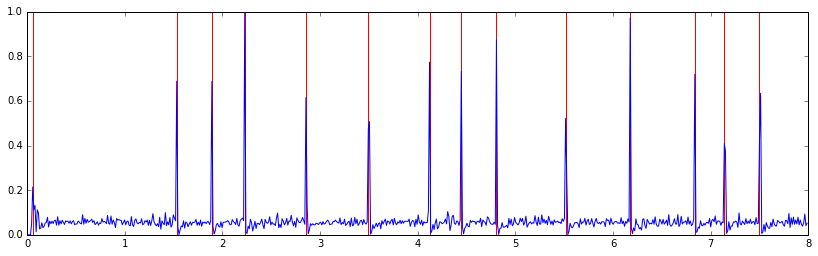

In [13]:
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
onset_times = librosa.frames_to_time(onset_frames, sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

plt.plot(t_frames, onset_env)
plt.vlines(onset_times, ymin=0, ymax=1, color="r")

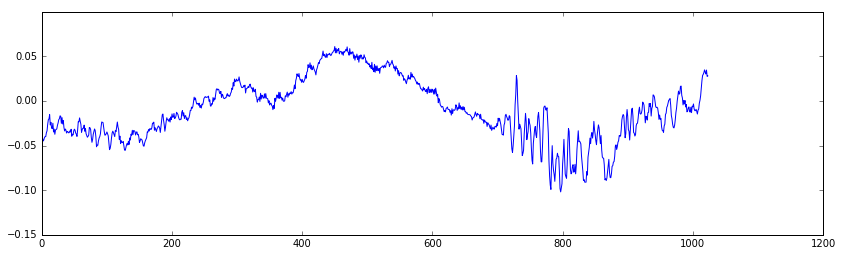

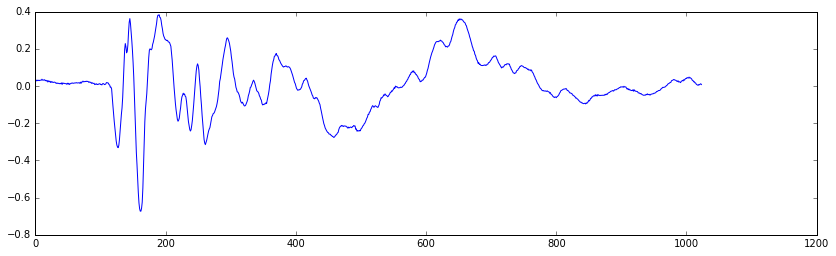

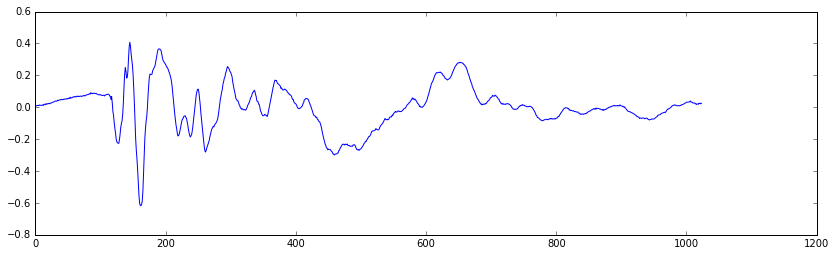

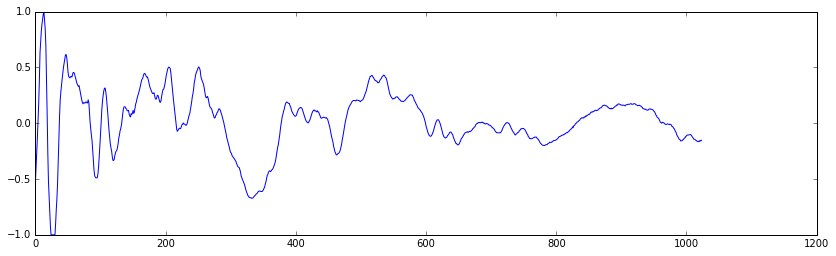

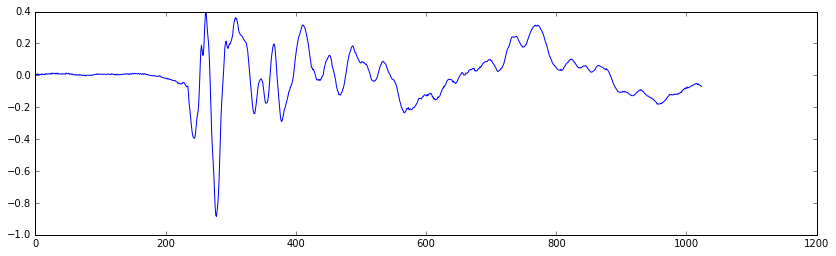

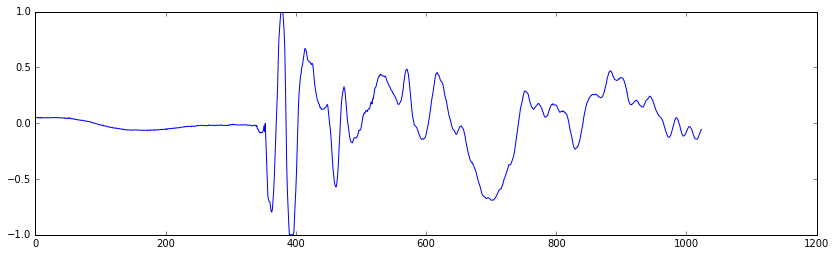

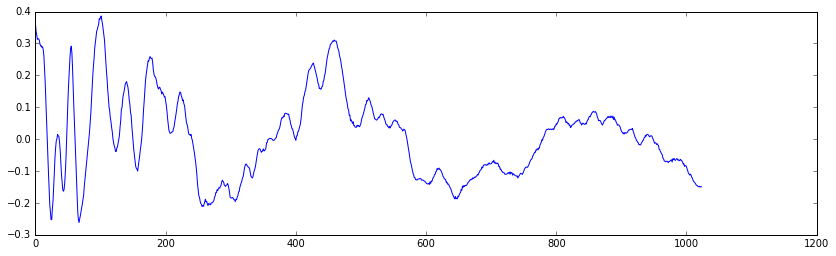

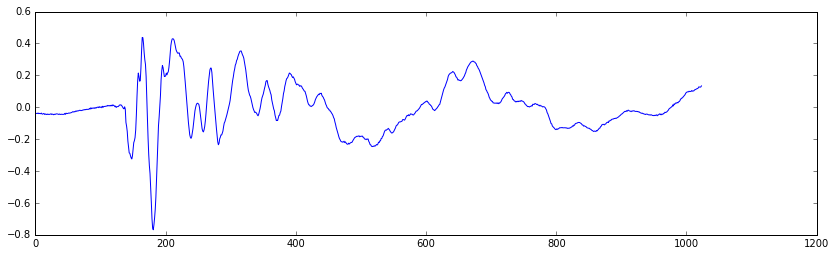

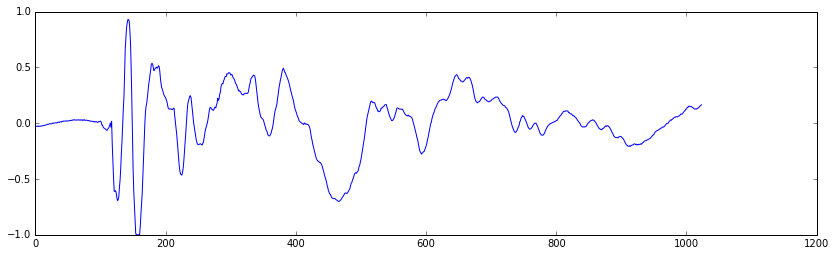

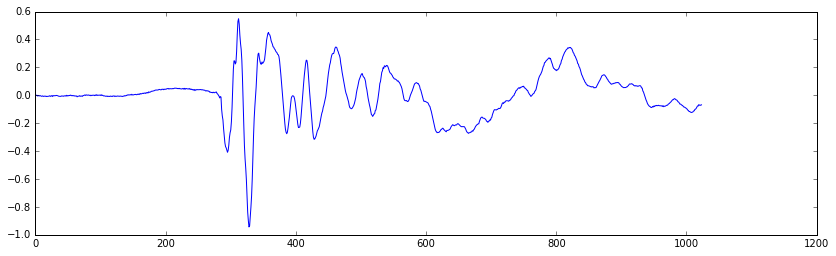

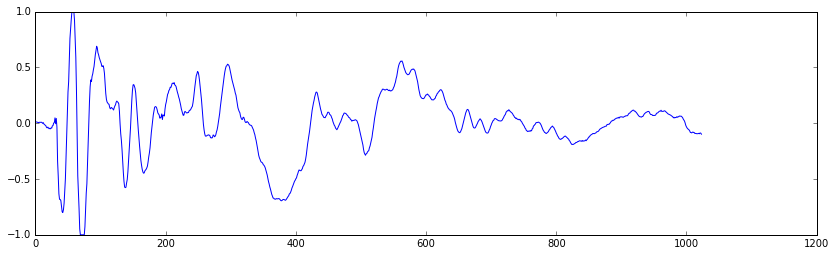

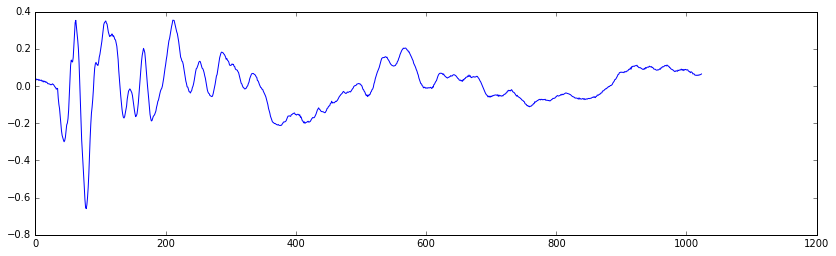

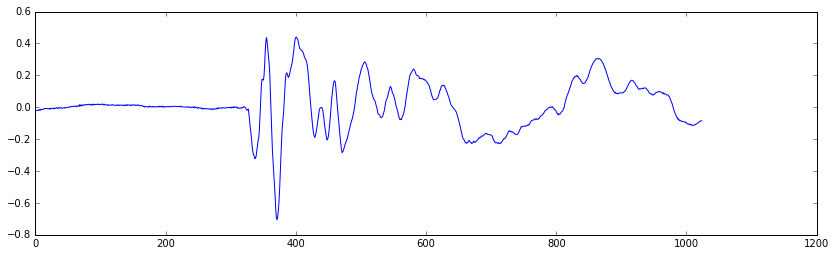

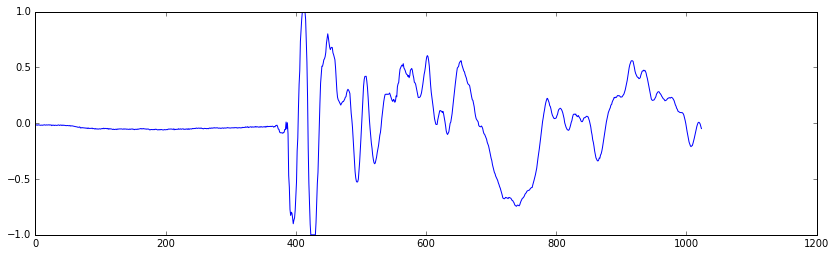

In [14]:
onset_block = []
for index in onset_samples:
    onset_waveform = x[index-HOP_LENGTH*2:index]
    onset_block.append(onset_waveform)
    plt.plot(onset_waveform)
    plt.show()

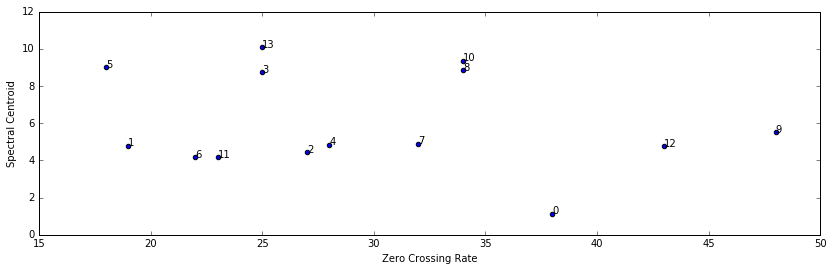

In [15]:
zcr = np.array([librosa.zero_crossings(xs).sum() for xs in onset_block])
cen = np.array([scipy.linalg.norm(xs) for xs in onset_block])

plt.scatter(zcr, cen)
ax = plt.gca()
for i in range(len(zcr)):
    ax.annotate(i, (zcr[i], cen[i]))
plt.xlabel("Zero Crossing Rate")
plt.ylabel("Spectral Centroid")

# realtime

In [125]:
import imp
imp.reload(ra)

<module 'realtime_analysis' from '/home/qislab-presentation/Documents/knock/realtime_analysis.py'>

In [126]:
WIN_LENGTH = 512*4
HOP_LENGTH = 512
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039


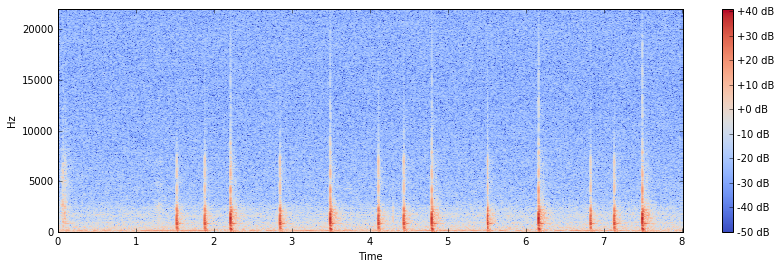

In [127]:
power_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                     ra.frame(WIN_LENGTH, HOP_LENGTH),
                     ra.power_spectrum(RATE, WIN_LENGTH),
                     ra.DataNode(ra.power2db))
power = np.stack(list(power_node)).T

librosa.display.specshow(power, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

In [128]:
Dt = HOP_LENGTH/RATE
PRE_MAX = int(0.03 / Dt)
POST_MAX = int(0.03 / Dt)
PRE_AVG = int(0.03 / Dt)
POST_AVG = int(0.03 / Dt)
WAIT = int(0.03 / Dt)
DELTA = 0.1

peak_node = ra.pick_peak(pre_max=PRE_MAX, post_max=POST_MAX,
                         pre_avg=PRE_AVG, post_avg=POST_AVG,
                         wait=WAIT, delta=DELTA)

envelope = []
onset_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                     ra.frame(WIN_LENGTH, HOP_LENGTH),
                     ra.power_spectrum(RATE, WIN_LENGTH),
                     ra.onset_strength(RATE/WIN_LENGTH, Dt),
                     ra.branch(ra.DataNode(envelope.append)),
                     peak_node)

onset = np.array(list(onset_node))
envelope = np.array(envelope)
t = np.arange(envelope.shape[0]) * (Dt)
onset_indices = (np.arange(envelope.shape[0]) - peak_node.delay)[onset]

(0, 3)

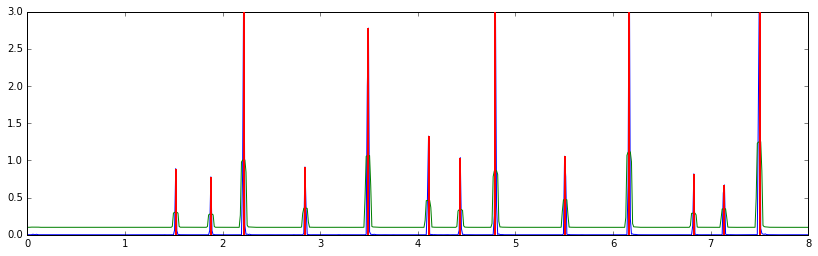

In [129]:
avg_threshold = scipy.ndimage.uniform_filter1d(envelope, 5) + 0.1
plt.plot(t, envelope)
plt.plot(t, avg_threshold)
plt.vlines(t[onset_indices], ymin=0, ymax=envelope[onset_indices], color="r", linewidth=2, zorder=3)
plt.ylim((0, 3))

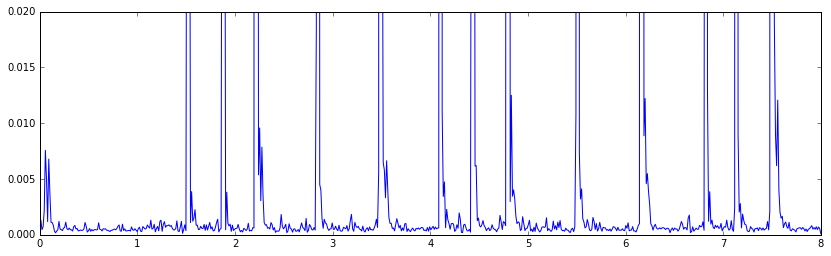

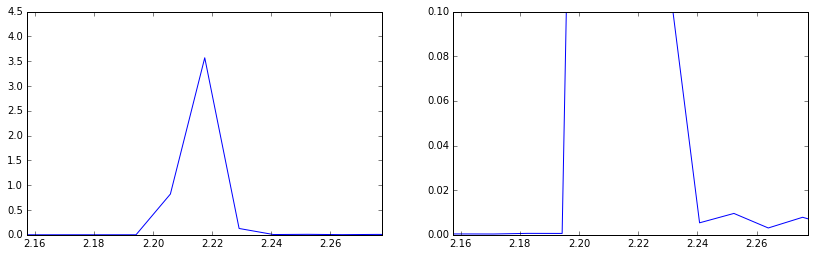

In [130]:
plt.plot(t, envelope)
plt.ylim((0, 0.02))
plt.show()
plt.subplot(121)
plt.plot(t, envelope)
plt.xlim((t[onset_indices[2]]-0.06, t[onset_indices[2]]+0.06))
plt.subplot(122)
plt.plot(t, envelope)
plt.xlim((t[onset_indices[2]]-0.06, t[onset_indices[2]]+0.06))
plt.ylim((0, 0.1))
plt.show()

0.0005511091320986593 0.0002422897504812445


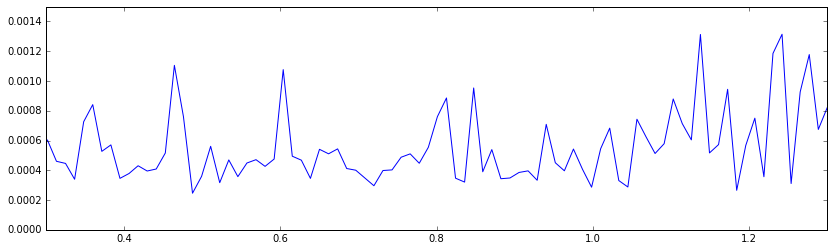

In [131]:
plt.plot(t, envelope)
plt.xlim((0.3, 1.3))
plt.ylim((0, 0.0015))
print(envelope[(t>0.3) & (t<1.3)].mean(), envelope[(t>0.3) & (t<1.3)].std())


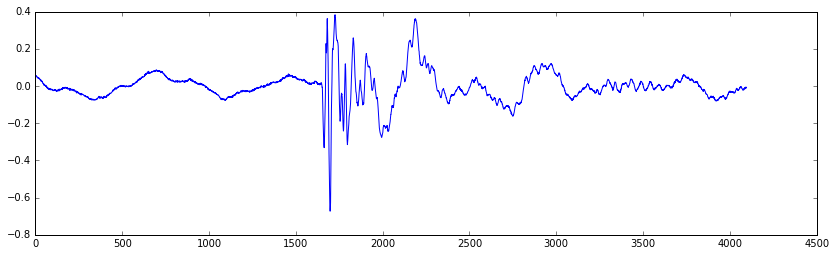

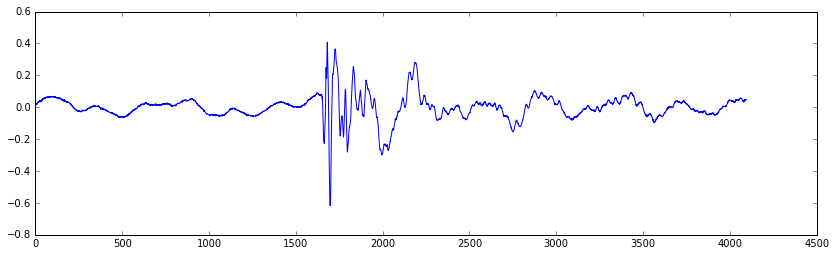

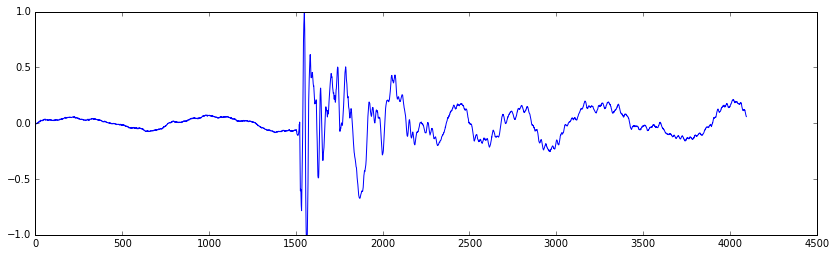

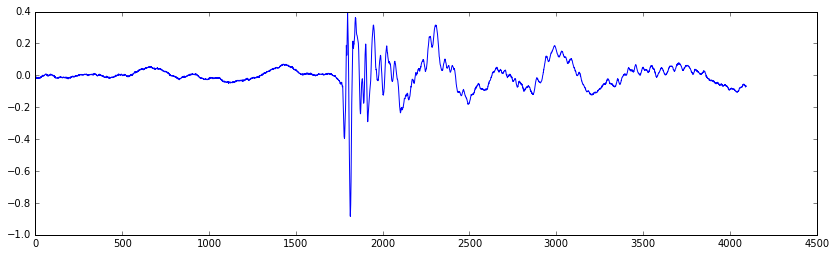

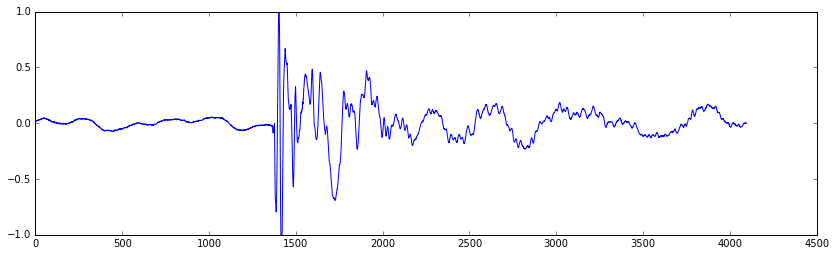

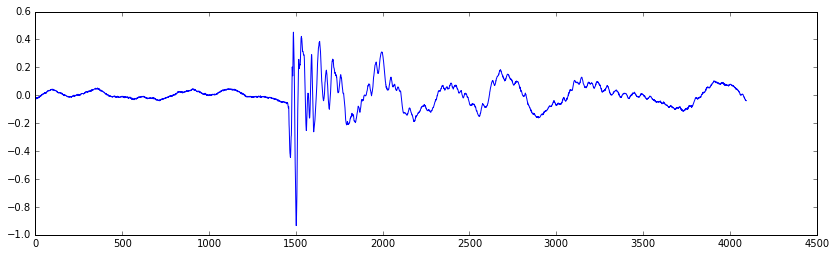

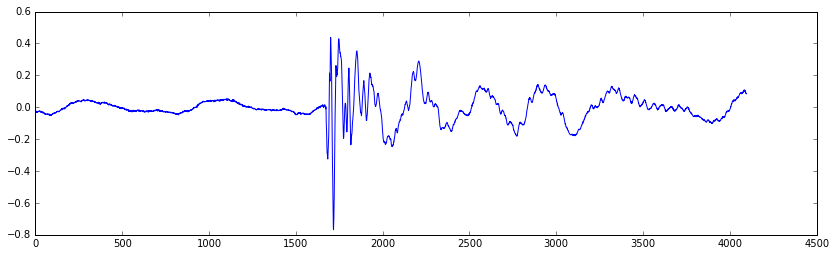

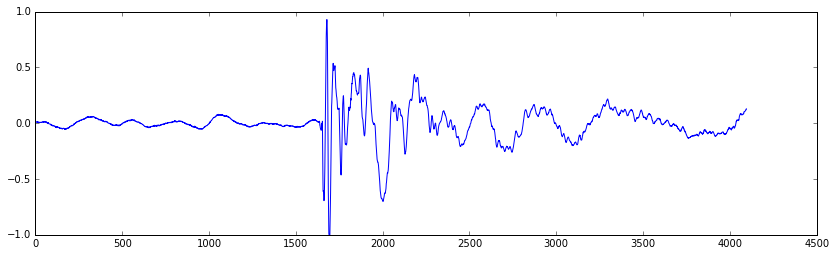

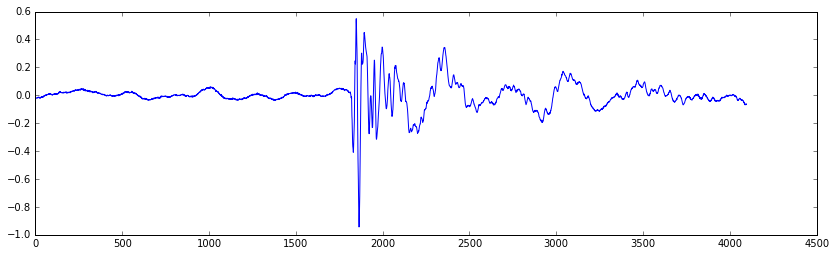

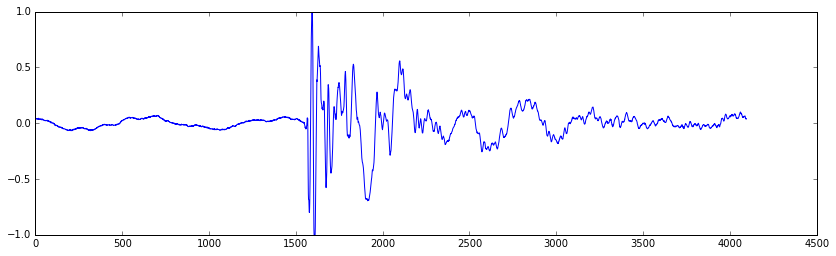

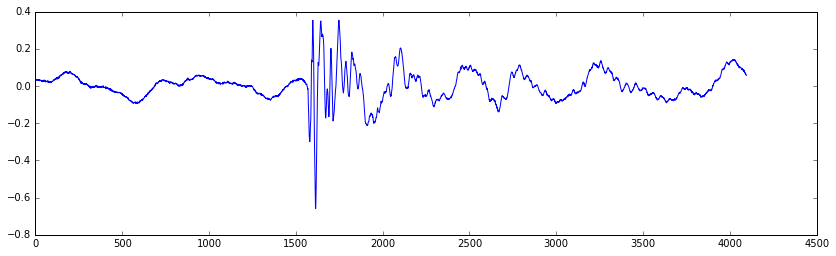

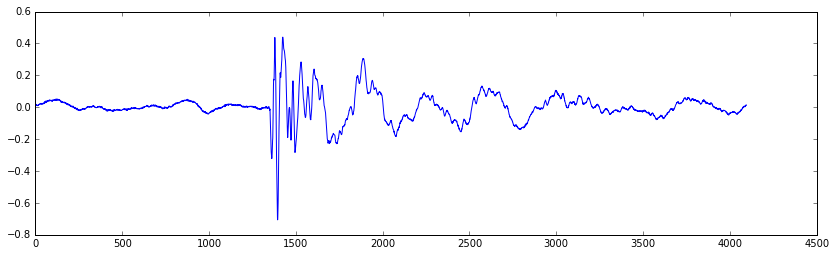

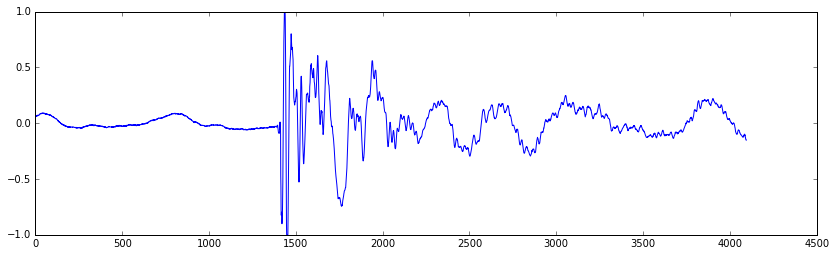

In [94]:
for i in onset_indices:
    plt.plot(x[i*HOP_LENGTH-WIN_LENGTH:i*HOP_LENGTH+WIN_LENGTH])
    plt.show()